<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from glob import iglob
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import re

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from collections import namedtuple
from datetime import datetime
Visit = namedtuple("Visit", ['user_id', 'timestamp','site','site_id'])

user_id_pattern = re.compile("(\d{4}).csv")
def extract_user_id(filename):
    return int(user_id_pattern.search(filename).group(1))

# generator of Visit tupples
# Example source: 2013-11-15 09:28:17,vk.com\n
def visit_generator(path_to_csv_files, site_freq_path):
    files = iglob(os.path.join(path_to_csv_files, '*.csv'))
    
    # site string -> (id, frequency)
    with open(site_freq_path, "rb") as f:
        dict = pickle.load(f) 
    
    for file in tqdm(files, desc = path_to_csv_files):
        user_id = extract_user_id(file)
        with open(file, 'r') as f:
            next(f) # skip header line            
            for line in f:
                split = line.strip().split(',')
                timestamp = datetime.strptime(split[0], '%Y-%m-%d %H:%M:%S')
                site = split[1]                                   
                site_id = dict[site][0]
                yield Visit(user_id, timestamp, site, site_id) 

In [4]:
visit_test = next(visit_generator(os.path.join(PATH_TO_DATA,'3users'), os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl')))
visit_test

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\3users', max=1), HTML(value='')))

Visit(user_id=1, timestamp=datetime.datetime(2013, 11, 15, 9, 28, 17), site='vk.com', site_id=1)

In [6]:
# accumulates visits of single user
# to form a session
class VisitAccumulator:
    def __init__(self, session_length, window_size):
        self.session_length = session_length
        self.window_size = window_size
        self.reset()
        
    def reset(self):
        self.user_id = -1
        self.visits = []

    def accumulate(self, visit: Visit):
        if (len(self.visits) == self.session_length):
            raise ValueError("accumulator is already full")
        
        user_id = visit.user_id
        if (self.user_id == -1):
            self.user_id = user_id
        elif (self.user_id != user_id):
            raise ValueError("user ids must be the same across visits")
        self.visits.append(visit)
        
    def isFull(self):
        return len(self.visits) == self.session_length
    
    def isEmpty(self):
        return len(self.visits) == 0
        
    def getSession(self):
        if (self.isEmpty()):
            raise ValueError("accumulator is exhausted")
        session = Session(self.session_length, self.visits)
        self.visits = self.visits[self.window_size:]
        return session
    
    def exhaust(self):
        while(not self.isEmpty()):
            yield self.getSession()
        self.reset()

#session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
#unique_sites – число уникальных сайтов в сессии
#start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
#day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)
class Session:
    def __init__(self, session_length, visits):
        assert len(visits) > 0
        
        self.session_length = session_length
        self.visits = visits
        
    def asData(self):
        visits = self.visits
        site_ids = list(map(lambda visit: visit.site_id, visits))
        time_diffs = list(map(lambda x: (x[1].timestamp - x[0].timestamp).total_seconds(),
                              zip(visits, visits[1:])))
        
        start = visits[0].timestamp
        end = visits[-1].timestamp
        timespan = (end - start).total_seconds()
        
        unique_sites = len(set(site_ids))
        start_hour = start.hour
        day_of_week = start.weekday()
        user_id = visits[0].user_id
        
        # site1..siteN,time1..timeN-1,timespan,unique_sites,start_hour,weekday,user
        result = np.zeros(self.session_length + (self.session_length - 1) + 1 + 4, dtype=int)
        np.put(result, range(len(site_ids)), site_ids)
        np.put(result, range(self.session_length, self.session_length + len(time_diffs)), time_diffs)
        
        result[-5] = timespan
        result[-4] = unique_sites
        result[-3] = start_hour
        result[-2] = day_of_week
        result[-1] = user_id
        return result

In [7]:
test_generator = visit_generator(os.path.join(PATH_TO_DATA,'3users'), os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'))
test_accumulator = VisitAccumulator(10, 3)
for i in range(10):
    test_accumulator.accumulate(next(test_generator))
session = test_accumulator.getSession()
session.asData()

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\3users', max=1), HTML(value='')))

array([   1,    2,    2,    3,    2,    4,    5,    6,    7,    8,  287,
       1184, 6278,  186,    2,    1,    2,    3,   55, 7998,    8,    9,
          4,    1])

In [8]:
#user1: 1 2 2 3 2 4 5 6 7 8 1 4 4 4 
#user2: 1 2 9 9 2 ...
def session_generator(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    assert window_size <= session_length
    
    accumulator = VisitAccumulator(session_length, window_size)
    
    prev_user_id = -1
    for visit in visit_generator(path_to_csv_files, site_freq_path):
        user_id = visit.user_id
        
        # if user is new
        if (prev_user_id != -1 and user_id != prev_user_id):
            # exhaust existing accumulator first
            yield from accumulator.exhaust()      
        
        # accumulate visits, if full yield session
        accumulator.accumulate(visit)
        if (accumulator.isFull()):
            yield accumulator.getSession()
        prev_user_id = user_id
        
    # exhaust if something was left
    yield from accumulator.exhaust()
                               
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    assert window_size <= session_length
    sessions = (session.asData() 
                for session in session_generator(path_to_csv_files, site_freq_path, session_length, window_size))
    return pd.DataFrame(sessions, columns=feature_names)


**Проверим функцию на игрушечном примере.**

In [9]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\3users', max=1), HTML(value='')))

In [10]:
train_data_toy #note: site_ids are different but sites are the same as in original notebook, so it's perfectly fine

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [12]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\10users', max=1), HTML(value='')))

Wall time: 5.94 s


In [13]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [14]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\150users', max=1), HTML(value='')))

Wall time: 36.9 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [15]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [16]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [17]:
train_data_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [18]:
train_data_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [19]:
train_data_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [20]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [21]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [22]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

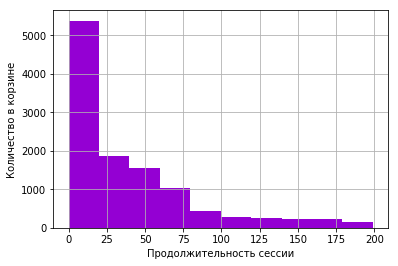

In [23]:
series = train_data_10users['session_timespan']
axes = series[series < 200].hist(color='darkviolet')
axes.set_xlabel("Продолжительность сессии")
axes.set_ylabel("Количество в корзине");

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

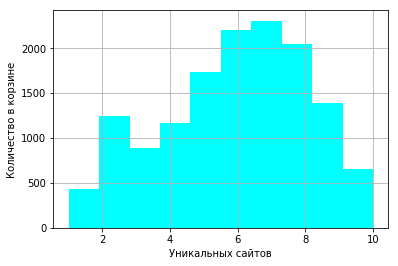

In [24]:
axes = train_data_10users['#unique_sites'].hist(color='aqua')
axes.set_xlabel("Уникальных сайтов")
axes.set_ylabel("Количество в корзине");

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

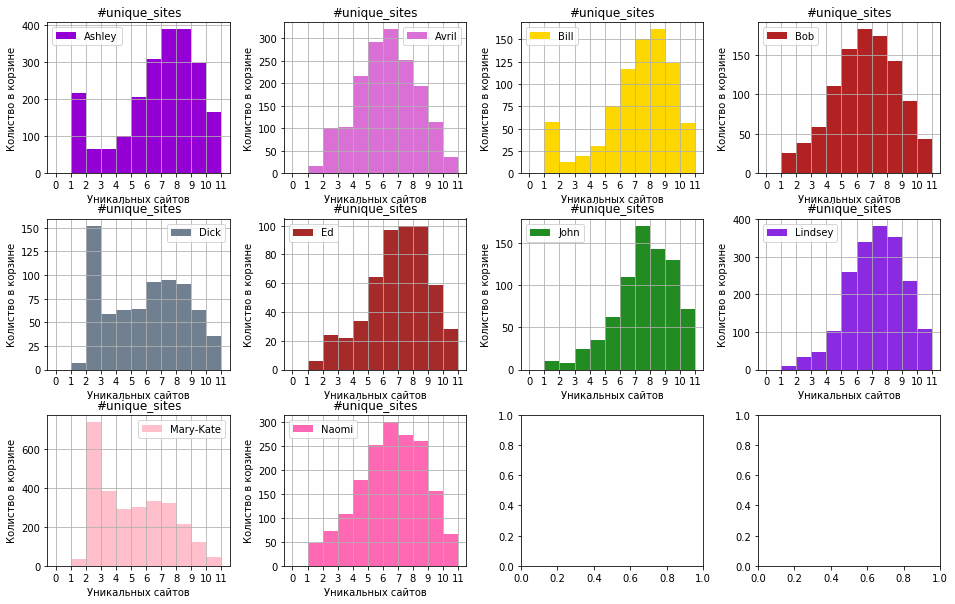

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df[['#unique_sites']].hist(ax=ax, label=user, color=color_dic.get(user), bins=range(12))
    ax.set_xlabel("Уникальных сайтов")
    ax.set_ylabel("Колиство в корзине")
    ax.set_xticks(np.arange(12))
    ax.legend()
    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

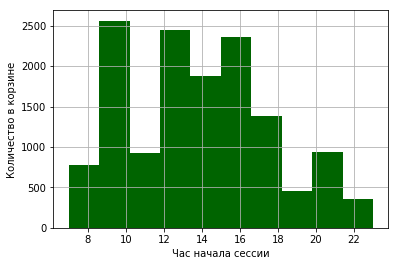

In [26]:
axes = train_data_10users['start_hour'].hist(color='darkgreen')
axes.set_xlabel("Час начала сессии")
axes.set_ylabel("Количество в корзине");

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

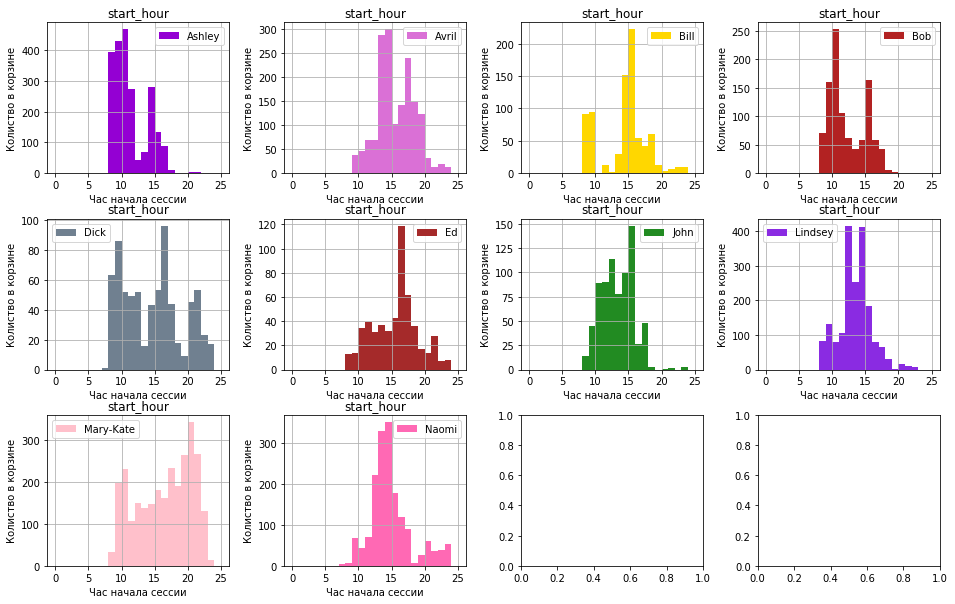

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df[['start_hour']].hist(ax=ax, label=user, color=color_dic.get(user), bins=range(26))
    ax.set_xlabel("Час начала сессии")
    ax.set_ylabel("Колиство в корзине")
    ax.legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

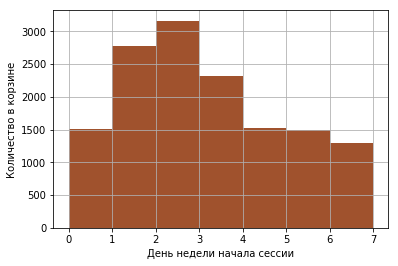

In [48]:
axes = train_data_10users['day_of_week'].hist(color='sienna', bins=range(8))
axes.set_xlabel("День недели начала сессии")
axes.set_ylabel("Количество в корзине");

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

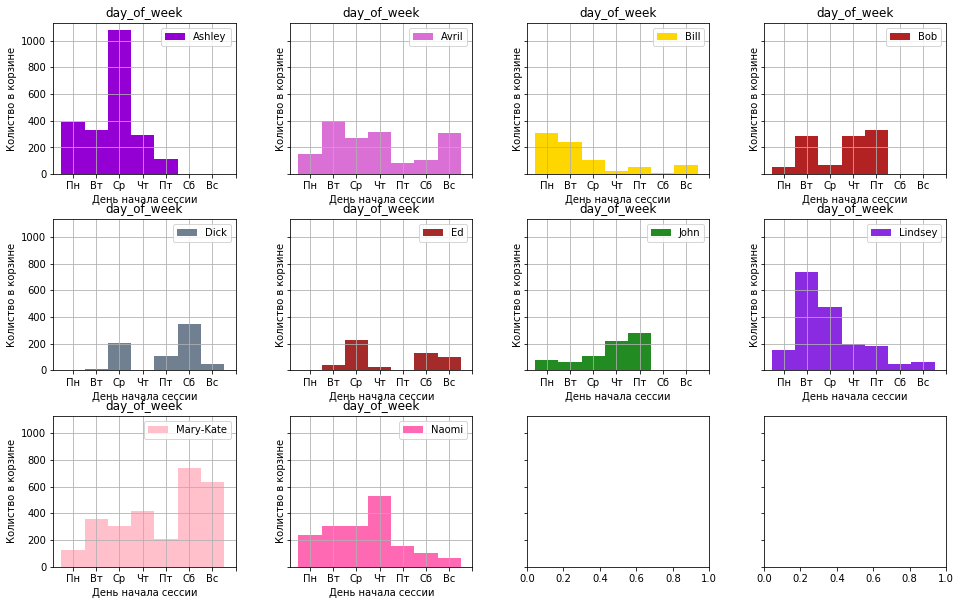

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True)

# как вариант, можно и по-другому
#pivot = pd.pivot_table(train_data_10users,
#                       index="target", columns="day_of_week", aggfunc='size', fill_value=0)
data = train_data_10users[["target", "day_of_week"]]
group = pd.groupby(data, 'target')
for idx, (user, sub_df) in  enumerate(group): 
    ax = axes[idx // 4, idx % 4]
    sub_df.hist(ax=ax, label=user, color=color_dic.get(user), bins=range(8))
    ax.set_xlabel("День начала сессии")
    ax.set_xticks(range(8))
    ax.set_xticks(np.arange(8)+0.5)
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.set_ylabel("Колиство в корзине")
    ax.legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Анализ приведён по графикам "на глаз". Заметно, что некоторые юзеры имеют особенности в поведении, кто-то не заходит по выходным, кто-то заходит с утра, но не на ночь, итд.

### Ashley
* unique site - чаще всего сессии содержат 7\8 сайтов
* start hour - чаще всего с утра и в районе 15-00, почти нет сессий после 18-00
* day of week - среда, и нет сессий на выходных

### Avril
* unique site - чаще всего сессии содержат 5\6\7 сайтов
* start hour - с 13-00 до 15-00 и в районе 17-00, малая активность после 20-00
* day of week - почти равномерно, кроме понедельника, пятницы и субботы, в которые сессий втрое меньше.

### Bill
* unique site - чаще всего сессии содержат 6/7/8/9 сайтов
* start hour - c 8-00 до 10-00 и около 15-00, малая активность после 20-00
* day of week - чаще всего выходит в понедельник, вторник, вдвое меньше в среду, и изредка в остальные дни, в субботу сессии реже всего

### Bob
* unique site - чаще всего сессии содержат 5/6/7/8 сайтов
* start hour - чаще всего в районе 10-00 и около 15-00, почти нет сессий после 18-00
* day of week - чаще всего вторник, четверг, пятница. Изредка в понедельник и среду. Почти ничего в субботу и воскресенье.

### Dick
* unique site - два пика: 2 сайта и 6\7\8 сайтов за сессию.
* start hour - начиная с 9-00 и до 24-00 исключая несколько провалов в районе 13-00 и 18-00
* day of week - очень мало сессий в понедельник, вторник, четверг и воскресенье. Среда, суббота - пики, пятница средне

### Ed
* unique site - чаще всего сессии содержат 5/6/7/8 сайтов
* start hour - немного с 8-00 до 10-00 и с 20-00 до 24-00, много сесиий около 16-00, 17-00, остальное время средне.
* day of week - чаще среда, суббота, воскресенье. немножко вторник и четверг. Почти ничего в понедельник и пятницу.

### John
* unique site - чаще всего сессии содержат 7/8/9 сайтов
* start hour - часто с 10-00 до 16-00 с пиком в в 15-00, почти нет после 18-00
* day of week - чаще четверг, пятница, почти ничего в выходные, остальные - средне

### Lindsey
* unique site - чаще 6/7/8 сайтов
* start hour - чаще с 12-00 до 15-00, довольно редко после 18-00б с 8-00 до 12-00 средне
* day of week - пик вторник, среда. Немного на выходных, остальные дни - средне.

### Mary-Kate 
* unique site - пик 2 сайта, очень редко 1, 9, 10 сайтов. Довольно часто остальные.
* start hour - пики 9-00, 10-00 и около 20-00, редко около 8-00 и 24-00, остльное - средне
* day of week - очень часто в выходные, редко в понедельник, остальное - средне

### Naomi
* unique site - чаще всего сессии содержат 5/6/7/8 сайтов
* start hour - пик с 12-00 до 15-00, немного с 9-00 до 11-00 и с 20-00. Очень редко 8-00, 9-00 и 18-00.
* day of week - до среды - средне, пик в четверг. Пятница редко, суббота реже, воскресенье ещё реже.


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [30]:
path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with open(path, "rb") as f:
    dict = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [31]:
import heapq
top10 = heapq.nlargest(10,dict.items(), key = lambda x: x[1][1])

top10_ids = set(map(lambda x: x[1][0], top10))
top10_freqs = list(map(lambda x: x[1][1], top10))
top10_sites = list(map(lambda x: x[0], top10))
top10

[('s.youtube.com', [210, 8300]),
 ('www.google.fr', [51, 7813]),
 ('www.google.com', [4, 5441]),
 ('mail.google.com', [183, 4158]),
 ('www.facebook.com', [15, 4141]),
 ('apis.google.com', [52, 3758]),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', [700, 3244]),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', [214, 3094]),
 ('plus.google.com', [187, 2630]),
 ('accounts.google.com', [184, 2089])]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

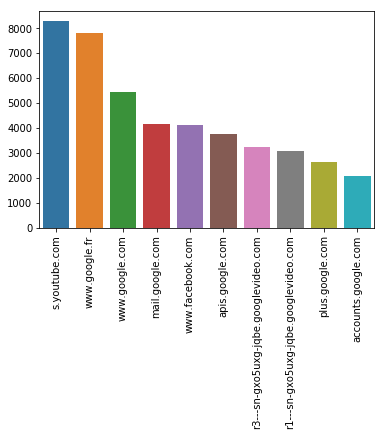

In [32]:
ax = sns.barplot(top10_sites, top10_freqs)
for item in ax.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [33]:
columns = feature_names + ["Month", "Year", "#top_site_visits"]
session_length = 10
window_size = 10

# session contains visits
# visit contains user_id, timestamp, site, site_id
def extractFeatures(session: Session):
    first_visit = session.visits[0]
    start_timestamp = first_visit.timestamp
    month = start_timestamp.month
    year = start_timestamp.year
    visited = list(map(lambda x: x.site_id, session.visits))
    visited_top = [site_id for site_id in visited if site_id in top10_ids]
    top_10_visits = len(visited_top)
    return np.append(session.asData(), [month, year, top_10_visits]) 

def feature_engineering(path_to_csv_files, site_freq_path, session_length=10):
    sessions = (extractFeatures(session) 
                for session in session_generator(path_to_csv_files, site_freq_path, session_length, window_size))
    return pd.DataFrame(sessions, columns=columns)

In [34]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\10users', max=1), HTML(value='')))

In [35]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

HBox(children=(IntProgress(value=1, bar_style='info', description='identification\\150users', max=1), HTML(value='')))

In [36]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,Month,Year,#top_site_visits
0,1,2,3,4,3,3,4,3,5,3,10,0,...,1,0,1,0,33,5,8,4,31,11,2013,2
1,6,7,8,9,3,10,11,12,13,14,1,0,...,1,3,3,8,284,10,8,4,31,11,2013,0
2,14,4,14,14,15,16,6,17,18,14,0,14,...,0,1,0,0,258,7,8,4,31,11,2013,2
3,19,20,19,14,14,14,14,21,22,23,2,1,...,1,0,0,0,30,6,8,4,31,11,2013,0
4,24,14,15,25,26,27,28,29,30,29,1,0,...,0,1,1,0,6,9,8,4,31,11,2013,1


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [37]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

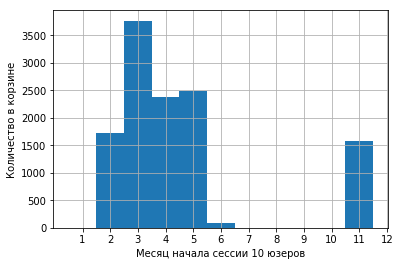

In [38]:
axes = new_features_10users['Month'].hist(bins=range(12))
axes.set_xticks(np.arange(12)+0.5)
axes.set_xticklabels(range(1,13))
axes.set_xlabel("Месяц начала сессии 10 юзеров")
axes.set_ylabel("Количество в корзине");

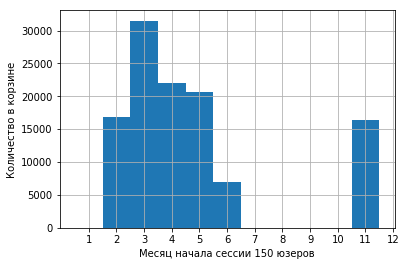

In [39]:
axes = new_features_150users['Month'].hist(bins=range(12))
axes.set_xticks(np.arange(12)+0.5)
axes.set_xticklabels(range(1,13))
axes.set_xlabel("Месяц начала сессии 150 юзеров")
axes.set_ylabel("Количество в корзине");

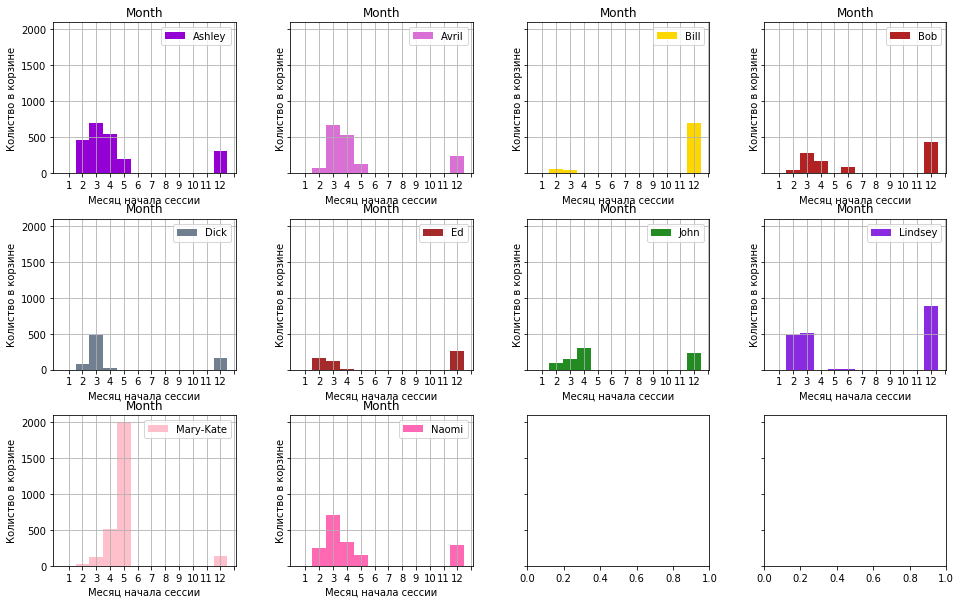

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True)

# как вариант, можно и по-другому
data = new_features_10users[["target", "Month"]]
group = pd.groupby(data, 'target')
for idx, (user, sub_df) in  enumerate(group):
    ax = axes[idx // 4, idx % 4]
    sub_df.hist(ax=ax, label=user, color=color_dic.get(user), bins=range(13))
    ax.set_xlabel("Месяц начала сессии")
    ax.set_xticks(np.arange(13)+0.5)
    ax.set_xticklabels(range(1,13))
    ax.set_ylabel("Колиство в корзине")
    ax.legend()

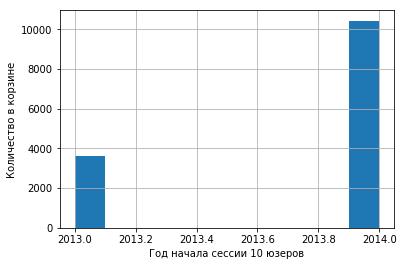

In [41]:
axes = new_features_10users['Year'].hist()
axes.set_xlabel("Год начала сессии 10 юзеров")
axes.set_ylabel("Количество в корзине");

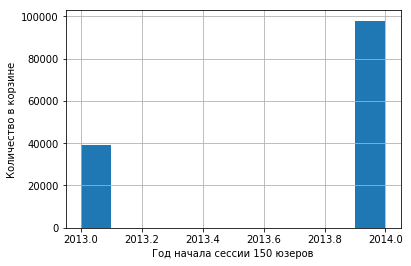

In [42]:
axes = new_features_150users['Year'].hist()
axes.set_xlabel("Год начала сессии 150 юзеров")
axes.set_ylabel("Количество в корзине");

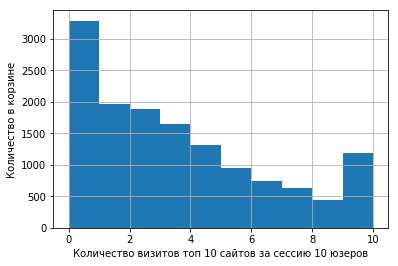

In [43]:
axes = new_features_10users['#top_site_visits'].hist()
axes.set_xlabel("Количество визитов топ 10 сайтов за сессию 10 юзеров")
axes.set_ylabel("Количество в корзине");

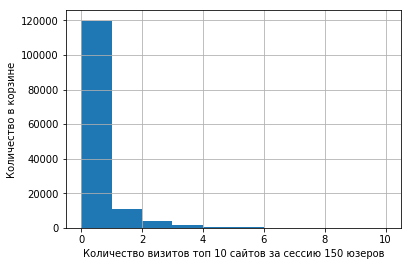

In [44]:
axes = new_features_150users['#top_site_visits'].hist()
axes.set_xlabel("Количество визитов топ 10 сайтов за сессию 150 юзеров")
axes.set_ylabel("Количество в корзине");

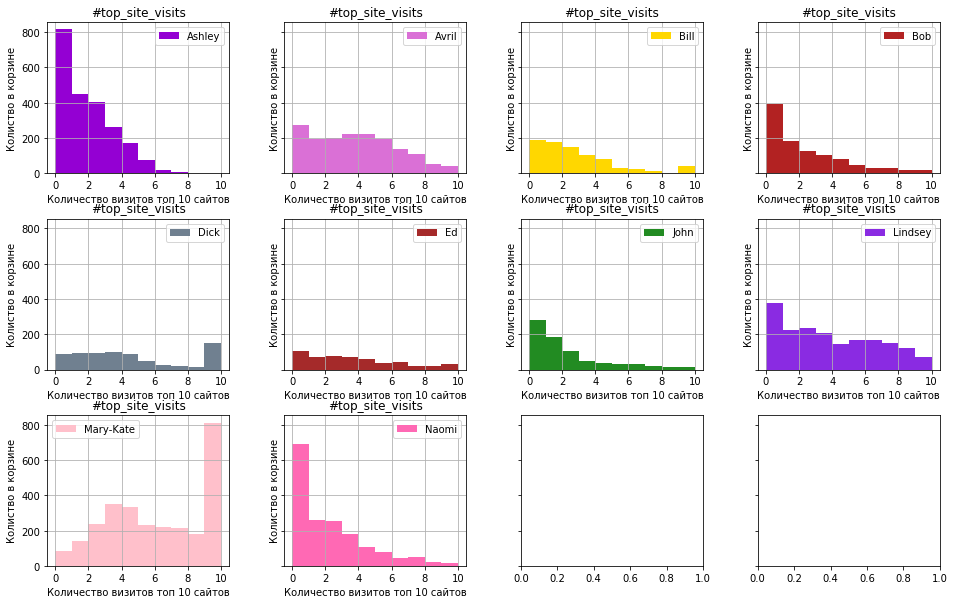

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharey=True)

# как вариант, можно и по-другому
data = new_features_10users[["target", "#top_site_visits"]]
group = pd.groupby(data, 'target')
for idx, (user, sub_df) in  enumerate(group):
    ax = axes[idx // 4, idx % 4]
    sub_df.hist(ax=ax, label=user, color=color_dic.get(user))
    ax.set_xlabel("Количество визитов топ 10 сайтов")
    ax.set_ylabel("Колиство в корзине")
    ax.legend()

Данные по месяцам и годам не внушают доверия (половина месяцев отсутствует по непонятной причине), так что использовать их я не стал бы. 
Количество визитов самых популярных сайтов за сессию лучше и можно попробовать использовать эти данные для обучения модели. Однако не уверен, что он сильно улучшит качество модели, так как для 150 юзеров подавлящее большинство сессий имеет 1-2 посещения топ сайтов. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [46]:
features = ["start_hour", "day_of_week", "#top_site_visits"]
selected_features_10users = new_features_10users[features]
selected_features_150users = new_features_150users[features]

In [47]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 